In [1]:
from fullfrlm import flow_refueling_location_model
from generate_network import generate_network
from flow_computation import flow_computation
from random_vessel_generator import random_vessel_generator
from first_stage_frlm import first_stage_frlm
from second_stage_frlm import second_stage_frlm
from visualize_placement import visualize_placement
import pickle
import time


## Load necessary data

In [2]:
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))

## Generate random df

In [12]:
%%time
df_chance = df_ivs.copy()
df_random1 = random_vessel_generator(df_chance, 1)

CPU times: total: 156 ms
Wall time: 138 ms



## Compute path flows

In [13]:
%%time
flows = flow_computation(df_random1)

CPU times: total: 250 ms
Wall time: 254 ms


## Generate network

In [ ]:
%%time
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
paths = pickle.load(open("data/final_paths.p", "rb"))
G, paths, inserted_nodes = generate_network(G, paths, 20)

In [ ]:
%%time
# range r in meters
df_b, df_g, df_eq_fq, feasible_combinations = first_stage_frlm(100000, G, OD=flows, paths=paths, path_lengths=path_lengths, df_h=df_h, additional_nodes=inserted_nodes)

## Run second stage FRLM

In [ ]:
%%time
optimal_facilities, optimal_flows, non_zero_flows, supported_flow, routes_supported = second_stage_frlm(100, 10, 5, df_g, df_b, df_eq_fq)

In [ ]:
sum(optimal_facilities.values())

In [ ]:
sum(optimal_flows.values())

In [ ]:
supported_flow

## Visualize placement

In [ ]:
%%time
visualize_placement(G, flows, optimal_facilities, non_zero_flows, df_h, paths, unused=True)

## Try out complete function

## range 50km

In [ ]:
total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported = flow_refueling_location_model(1, 50000, 100, 5, 5, vis=False)

In [ ]:
total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported = flow_refueling_location_model(1, 10000, 100, 5, 5, 30, vis=True)

In [ ]:
fraction_captured_total

In [ ]:
serveable_fraction

In [ ]:
served_fraction

Optimal


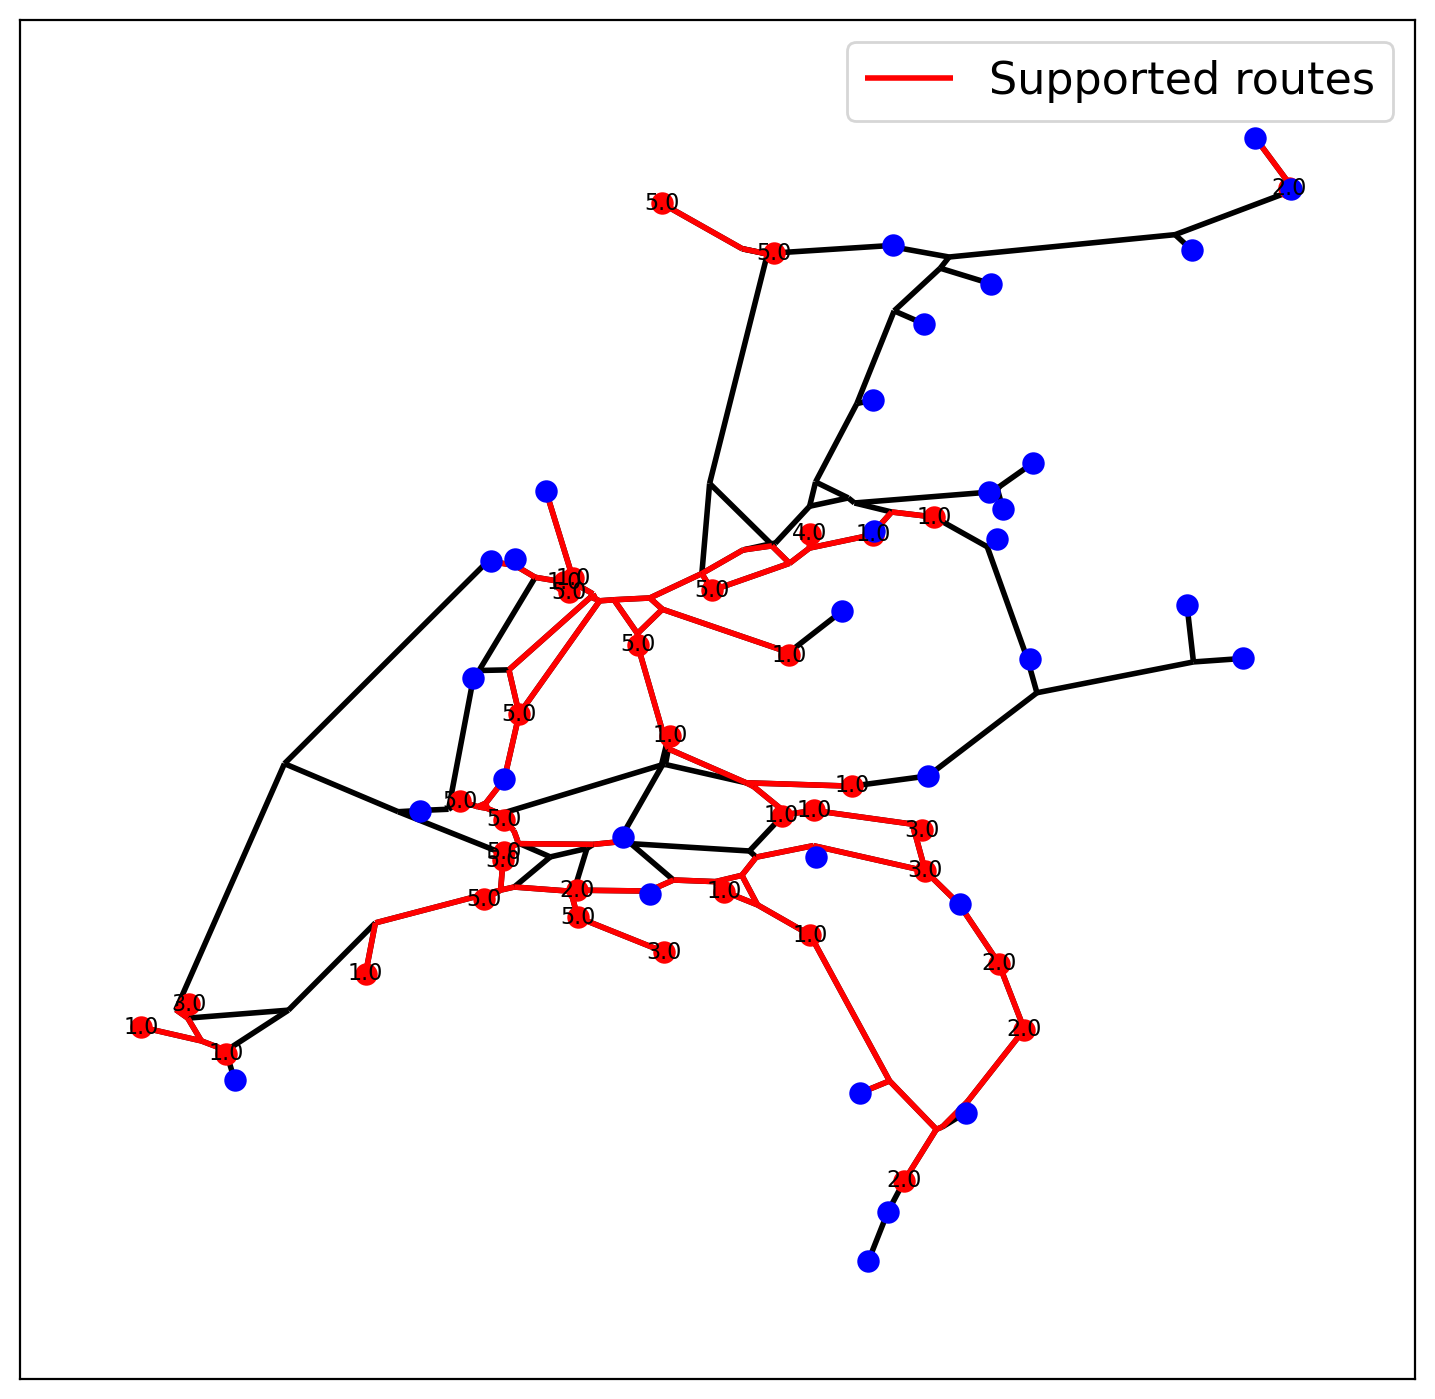

0.2755612194897524

In [13]:
total_flow, supported_fraction, optimal_facilities, non_zero_flows, routes_supported = flow_refueling_location_model(1, 100000, 100, 5, 5, vis=True)
supported_fraction

Optimal


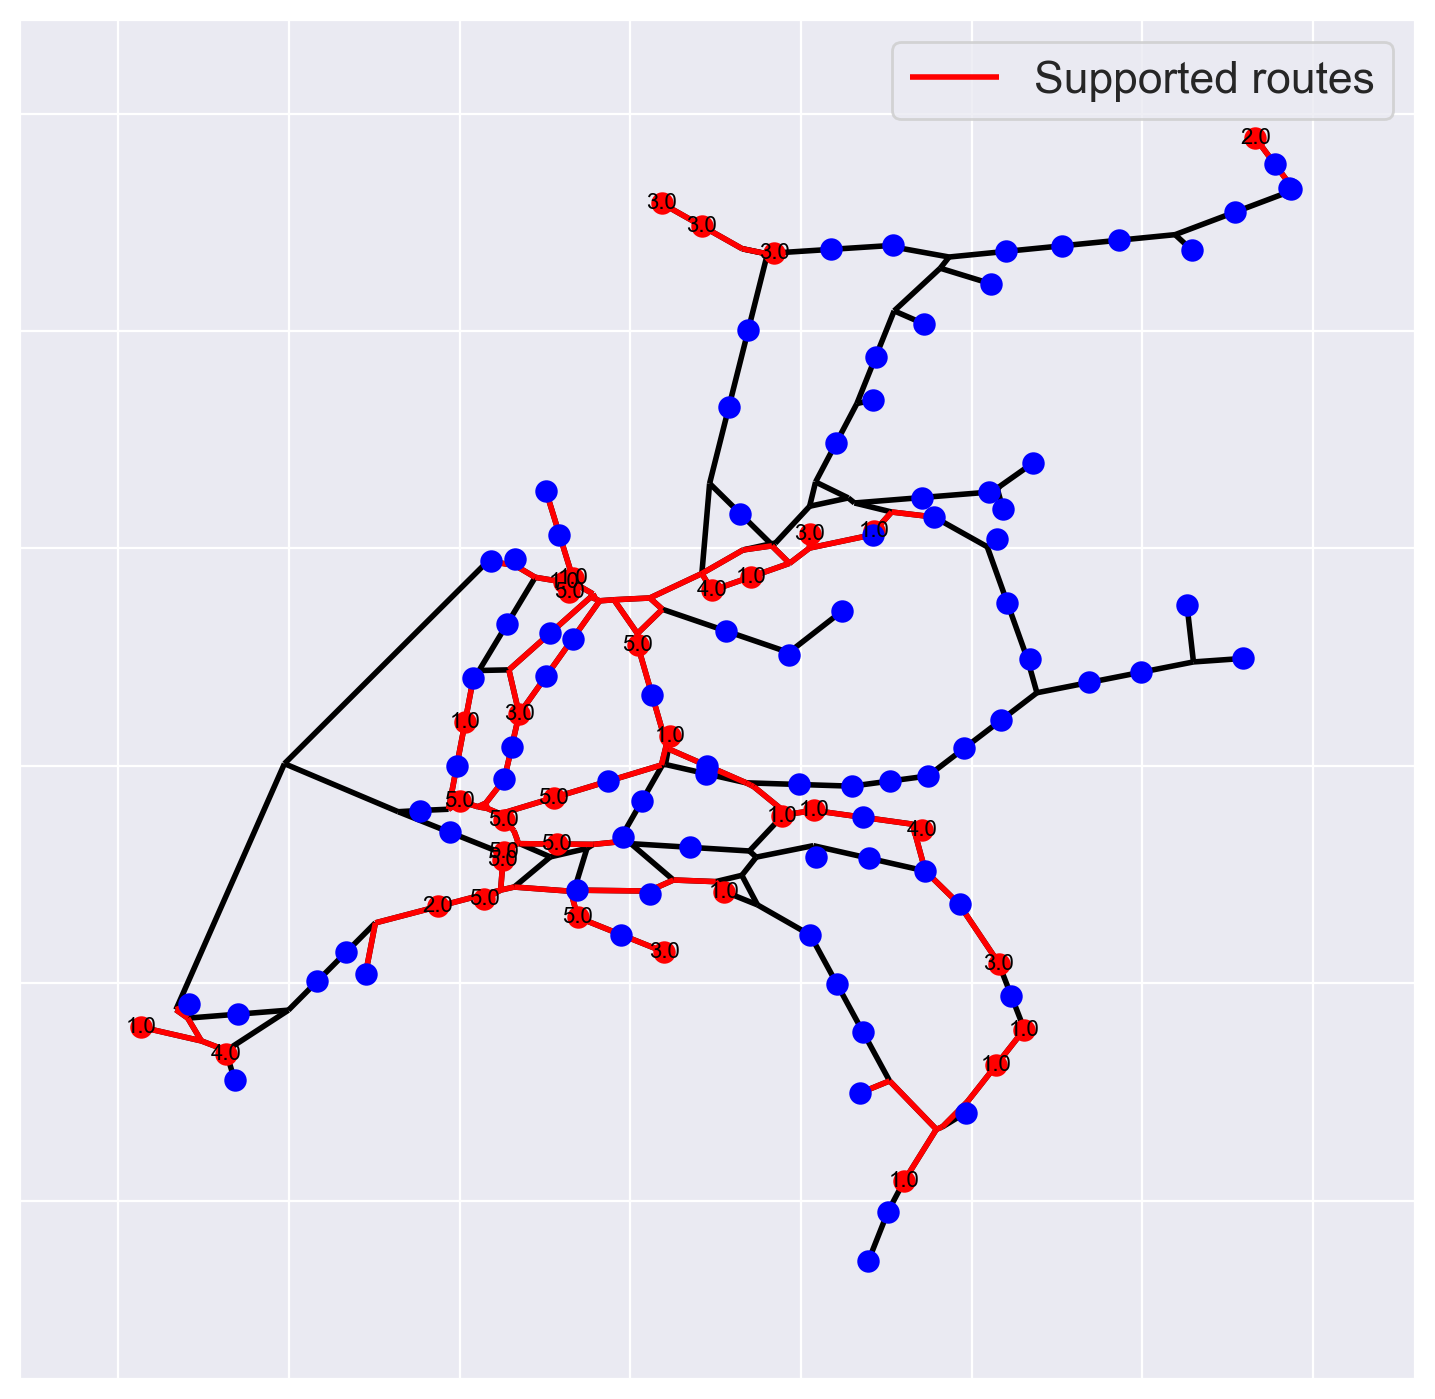

In [3]:
total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_nodes_abm, df_links_abm = flow_refueling_location_model(1, 100000, 100, 5, 5, 50, vis=True)

In [4]:
df_nodes_abm

,X,Y,node_type,charging_stations
30986055,5.402429,53.177448,intermediate_node,0.0
8866889,4.832089,52.431155,harbour,1.0
30984595,4.572310,51.692559,harbour,5.0
8862690,5.525170,52.500915,intermediate_node,0.0
8862907,5.054208,51.711968,intermediate_node,0.0
...,...,...,...,...
144,5.225622,52.000003,inserted_node,0.0
150,4.831751,52.292716,inserted_node,0.0
151,4.753135,52.205884,inserted_node,0.0
159,4.652718,52.043935,inserted_node,0.0


In [ ]:
import time
%time total_flow, supported_fraction, optimal_facilities, non_zero_flows, routes_supported = flow_refueling_location_model(1, 100000, 100, 5, 5, 0, vis=True)

In [5]:
non_zero_flows

[('NLABL', 'NLRTM', 0),
 ('NLAER', 'NLLEY', 0),
 ('NLAER', 'NLLEY', 0),
 ('NLAER', 'NLRTM', 0),
 ('NLAER', 'NLSWI', 0),
 ('NLALK', 'NLIJM', 0),
 ('NLALK', 'NLIJM', 0),
 ('NLAMS', 'NLAER', 0),
 ('NLAMS', 'NLTIE', 0),
 ('NLAMS', 'NLUTC', 1),
 ('NLAMS', 'NLWMO', 0),
 ('NLAMS', 'NLZAA', 0),
 ('NLDOR', 'NLRTM', 0),
 ('NLDOR', 'NLRTM', 1),
 ('NLDRO', 'NLKAM', 0),
 ('NLFAR', 'NLEEM', 0),
 ('NLGOR', 'NLRTM', 0),
 ('NLHAR', 'NLWTE', 0),
 ('NLHAR', 'NLWTE', 0),
 ('NLHTB', 'NLBON', 0),
 ('NLHTB', 'NLBZM', 0),
 ('NLIJM', 'NLRTM', 1),
 ('NLKGZ', 'NLAMS', 0),
 ('NLKGZ', 'NLZAA', 0),
 ('NLLEY', 'NLAMS', 0),
 ('NLMOE', 'NLOOS', 0),
 ('NLNIJ', 'NLAMS', 0),
 ('NLNIJ', 'NLDRU', 0),
 ('NLNIJ', 'NLDRU', 0),
 ('NLNIJ', 'NLWAS', 0),
 ('NLNIJ', 'NLWAS', 0),
 ('NLNRW', 'NLBON', 0),
 ('NLOOS', 'NLTLB', 0),
 ('NLOOS', 'NLTLB', 0),
 ('NLRTM', 'NLAPN', 0),
 ('NLRTM', 'NLGTB', 1),
 ('NLRTM', 'NLLID', 0),
 ('NLRTM', 'NLMOE', 0),
 ('NLRTM', 'NLMOE', 0),
 ('NLRTM', 'NLMOE', 1),
 ('NLRTM', 'NLOOS', 1),
 ('NLRTM', 'NLOO